# Learning coins similarity
- http://pythonexample.com/code/image-similarity-tensorflow/
- https://github.com/debarko/CapsNet-Tensorflow
- https://github.com/XifengGuo/CapsNet-Keras

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
from scipy.ndimage.interpolation import rotate

%run ../common/datasets.ipynb
%run ../common/visualisation.ipynb

%matplotlib inline

## Load data

In [2]:
def load_coins_dataset(ndata):
    return load_image_dataset(
        img_shape = [128, 128, 1],
        path      = "/netforge/datasets/private/roman/coins/images",
        ndata     = ndata)

In [38]:
data_size = 2000
(
    image_shape, 
    file_num,
    train_images, 
    train_labels, 
    test_images, 
    test_labels
) = load_coins_dataset(data_size)

print("File num   :", file_num)
print("Data size  :", data_size)
print("Train shape:", list(train_images.shape))
print("Test  shape:", list(test_images.shape))
print("Image shape:", image_shape)

File num   : 2629
Data size  : 2000
Train shape: [2000, 16384]
Test  shape: [2000, 16384]
Image shape: [128, 128, 1]


## Visualisation

Train images:


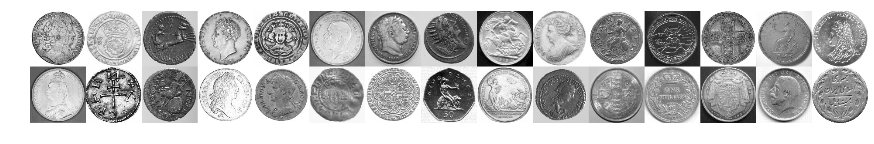

Test images:


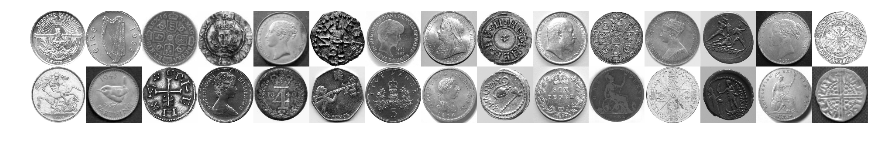

In [39]:
print("Train images:")
show_images(train_images, image_shape, rows=2, cols=15)
print("Test images:")
show_images(test_images, image_shape, rows=2, cols=15)

### Augmentation

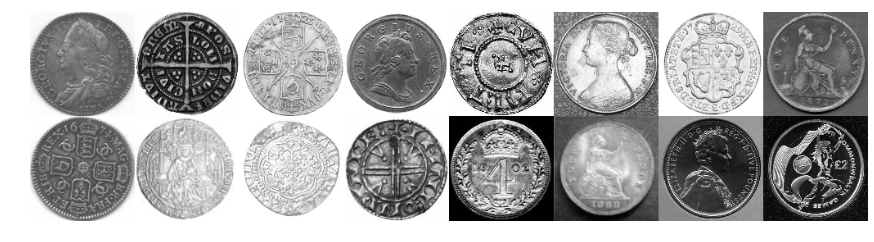

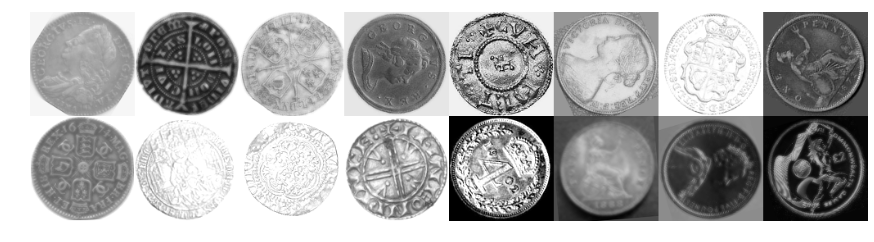

In [42]:
aug_cache      = dict()
aug_cache_size = 42

augment_params = {
    'smooth'    : .8,
    'angle'     : 90,
    'brightness': .25,
    'contrast'  : [.5, 1.5],
}
def augment(im, use_cache=True, rate=1):
    shape = im.shape
    w = shape[1]
    h = shape[0]
    if use_cache:
        hc = hash(im.tostring())
        cached = aug_cache.get(hc, [])
        if len(cached)>=aug_cache_size:
            return np.copy(cached[np.random.randint(aug_cache_size)])

    im = np.copy(im)
    
    # smooth
    p = augment_params['smooth']
    k = p*np.random.random(1)**2 * rate
    if k > 0.1:
        kernel = np.ones([5,5],np.float32)/25
        old= np.copy(im)
        im = cv2.filter2D(im,-1,kernel)
        im = np.reshape(im, shape)
        im = k*im + (1-k)*old
    
    # angle
    p = augment_params['angle']
    k = np.random.uniform(-p, p) * rate
    c = np.mean(im[:10,:10])
    im[0,:]   = c
    im[h-1,:] = c
    im[:,0]   = c
    im[:,w-1] = c
    im = rotate(im, k, reshape=False, mode='nearest')

    # brightness
    p = augment_params['brightness']
    k = np.random.uniform(1-p, 1+p) * rate
    im = im * k
    im = np.minimum(im,1)
    im = np.maximum(im,0)

    # contrast
    p = augment_params['contrast']
    k = rate*np.random.uniform(*p) + (1-rate)
    im = np.power(im, k)

    # bounding
    assert np.all(im<=1)
    assert np.all(im>=0)

    # cache
    if use_cache:
        cached.append(im)
        aug_cache[hc] = cached
    return im

def test_augment():
    n = 16
    s = np.random.randint(data_size-n)
    im1 = np.reshape(train_images[s:s+n], [-1,] + image_shape)
    im2 = np.copy(im1)
    for i in range(n):
        im2[i] = augment(im2[i], use_cache=False, rate=1)
    print("Original:")
    show_images(im1, image_shape[:2], cols=n//2, rows=2)
    print("Augmented:")
    show_images(im2, image_shape[:2], cols=n//2, rows=2)

test_augment()

## Neural Networks

In [43]:
def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
    l = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=tf.nn.relu)
    return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)

def SimilarityNet(image1, image2):
    l = tf.concat([image1, image2], axis=1)
    l = conv2d_maxpool(l, 16)
    l = conv2d_maxpool(l, 32)
    l = conv2d_maxpool(l, 64)
    l = conv2d_maxpool(l, 128)
    l = tf.contrib.layers.flatten(l)
    l = tf.layers.dense(l, units=500, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=2)
    logits = l
    pred   = tf.nn.softmax(logits)
    
    return logits, pred

def sim_loss(true, pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true, logits=pred))

### Graph

In [44]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('similarity'):
        with tf.device('/gpu:0'):
            image1_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image1')
            image2_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image2')
            true_pl   = tf.placeholder(dtype=tf.float32, shape=[None, 2], name='true')
            lr_pl     = tf.placeholder(dtype=tf.float32, name='lr')
            logits_op, pred_op = SimilarityNet(image1_pl, image2_pl)
            loss_op   = sim_loss(true_pl, logits_op)
            train_op  = tf.train.AdamOptimizer(lr_pl).minimize(loss_op)
            init_op   = tf.global_variables_initializer()

### Batching

['       1', '       1', '       0', '       0', '       1', '       1', '       0', '       0']


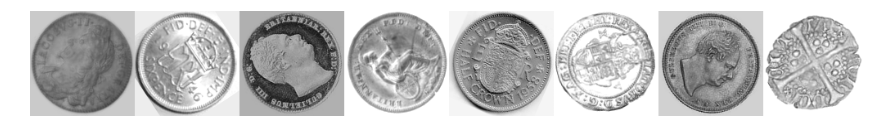

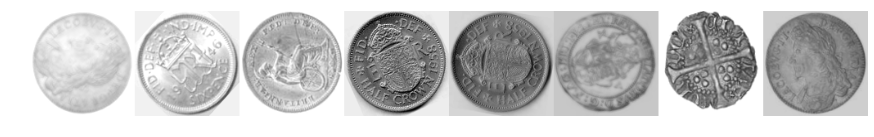

CPU times: user 844 ms, sys: 244 ms, total: 1.09 s
Wall time: 777 ms


In [45]:
%%time
def get_next_batch(bs):
    idx = np.random.choice(np.arange(len(train_images)), bs)
    img1 = np.copy(train_images[idx])
    
    per = np.arange(bs)
    per = np.roll(per, shift=1+np.random.randint(bs-1))
    
    img1 = np.reshape(img1, [-1,]+image_shape)
    img2 = img1[per]
    true = np.zeros([bs,2])
    same = np.random.randint(2, size=bs)
    
    for i in range(bs):
        true[i,same[i]] = 1.
        if same[i]:
            img2[i] = augment(img1[i])
            img1[i] = augment(img1[i])
        else:
            img1[i] = augment(img1[i])
            img2[i] = augment(img2[i])
    
    return img1, img2, true

def test_batching():
    n = 8
    im1, im2, t = get_next_batch(n)
    print(["%8d"%t[i][1] for i in range(len(im1))])
    show_images(im1, image_shape[:2], cols=n, rows=1)
    show_images(im2, image_shape[:2], cols=n, rows=1)

test_batching()

### Train

In [48]:
try:
    sess.close()
except:
    pass
sess = tf.Session(graph=graph)
sess.run(init_op)

learning_rate = 1e-4
batch_size    = 256
print("data_size     : %d"   % data_size)
print("batch_size    : %d"   % batch_size)
print("aug_cache_size: %d"   % aug_cache_size)
print("learning_rate : %.0e" % learning_rate)

data_size     : 2000
batch_size    : 256
aug_cache_size: 42
learning_rate : 1e-04


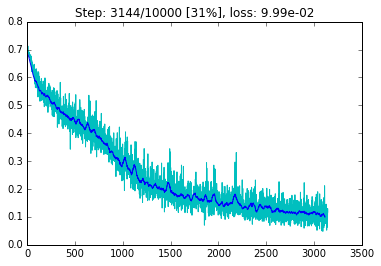

CPU times: user 40min 57s, sys: 15min 35s, total: 56min 32s
Wall time: 42min 50s


In [49]:
%%time
def train(step_num, log_every=1, mean_win = 30):
    try:
        losses   = []
        for step in range(step_num):
            img1, img2, true = get_next_batch(batch_size)
            _, loss = sess.run([train_op, loss_op], feed_dict={
                image1_pl: img1,
                image2_pl: img2,
                true_pl  : true,
                lr_pl    : learning_rate
            })
            losses.append(loss)
            if step % log_every == log_every-1:
                show_losses(losses, step, step_num, mean_win)
            if np.mean(losses[-mean_win:]) < .1:
                break
    except KeyboardInterrupt:
        pass
    show_losses(losses, step, step_num, mean_win)
    
train(10000)

### Find similar images

0.94 0.95 0.90 0.98 0.96 0.95 0.91 0.94 0.99 0.99 0.97 0.89 1.00 0.99 0.93 0.92 0.93 0.99 0.94 0.95
==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ====


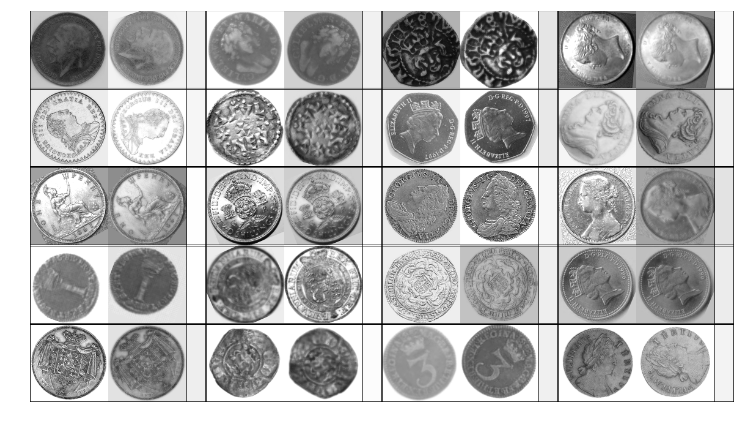

0.00 0.26 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.28 0.01 0.00 0.00 0.01
                                                                                                   


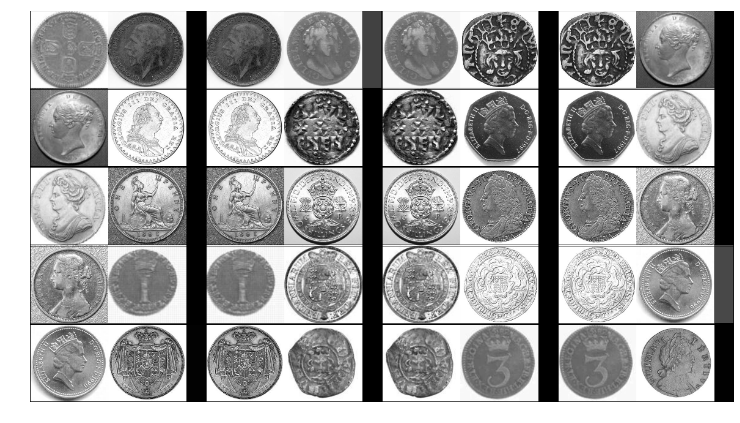

CPU times: user 1.88 s, sys: 412 ms, total: 2.29 s
Wall time: 1.96 s


In [68]:
%%time
def get_similarity(img1, img2, use_aug):
    img1 = np.copy(np.reshape(img1, [-1,]+image_shape))
    img2 = np.copy(np.reshape(img2, [-1,]+image_shape))
    if use_aug:
        for i in range(len(img2)):
            img1[i] = augment(img1[i], use_cache = False)
            img2[i] = augment(img2[i], use_cache = False)
    pred = sess.run(pred_op, feed_dict = {
        image1_pl: img1,
        image2_pl: img2
    })
    sim = pred[:,1]
    return img1, img2, sim

def show_coins_sim(img1, img2, sim, cols=4):
    h  = image_shape[0]
    w  = image_shape[1]
    w3 = 32
    img1 = np.copy(img1.reshape([num*h,w]))
    img2 = np.copy(img2.reshape([num*h,w]))
    img3 = np.ones([num*h, w3])
    for i in range(num):
        s = sim[i]
        assert(0.<=s<=1.)
        img3[i*h:i*h+h] = s
    img1[:,0] = 0
    img3[:,w3-1] = 0
    img3[:,0] = 0
    sheet = np.concatenate([img1, img2, img3], axis=1)
    sheet[np.arange(0,h*num,h)-1,:] = 0
    sheet[np.arange(0,h*num,h)+1,:] = 0
    sheet = np.minimum(sheet, 1)
    print(' '.join(['%.2f'%s for s in sim]))
    print(' '.join(['='*4 if s>.5 else ' '*4 for s in sim]))    
    show_images(images=sheet, image_shape=[h, 2*w+w3], cols=cols, rows=num//cols)

def test_similarity(images1, images2, num, use_aug=True):
    img1, img2, sim = get_similarity(images1[:num], images2[:num], use_aug)
    show_coins_sim(img1, img2, sim)
    
num = 20
shift = np.random.randint(data_size)
test_similarity(
    images1  = np.roll(test_images, shift, axis=0), 
    images2  = np.roll(test_images, shift, axis=0), 
    num      = num,
    use_aug  = True)
test_similarity(
    images1  = np.roll(test_images, shift+1, axis=0), 
    images2  = np.roll(test_images, shift  , axis=0), 
    num      = num,
    use_aug  = False)

Data size               : 500
Mean positive similarity: 92.1%
Mean negative similarity: 4.6%


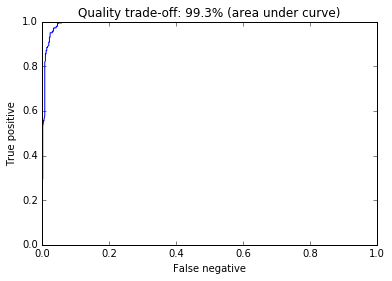

CPU times: user 7.37 s, sys: 416 ms, total: 7.78 s
Wall time: 7.65 s


In [64]:
%%time
def calc_pos_similarity(ds, num, use_aug=True):
    shift = np.random.randint(len(ds))
    img1 = np.roll(ds, shift, axis=0)[:num]
    img2 = np.roll(ds, shift, axis=0)[:num]
    _, _, sim = get_similarity(img1, img2, use_aug)
    return sim
    
def calc_neg_similarity(ds, num, use_aug=True):
    shift = np.random.randint(len(ds))
    img1 = np.roll(ds, shift+1, axis=0)[:num]
    img2 = np.roll(ds, shift  , axis=0)[:num]
    _, i_, sim = get_similarity(img1, img2, use_aug)
    return sim

def show_quality(pos_sim, neg_sim):
    print("Data size               :", len(pos_sim))
    print("Mean positive similarity: %.1f%%" % (np.mean(pos_sim)*100))
    print("Mean negative similarity: %.1f%%" % (np.mean(neg_sim)*100))
    n = 1000
    x = np.zeros(n)
    y = np.zeros(n)
    s = 0
    for i in range(n):
        p = i/n
        x[i] = 1 - np.mean(neg_sim < p)
        y[i] = np.mean(pos_sim > p)
        if i>0:
            s += (y[i]+y[i-1])/2 * (x[i-1]-x[i])
    plt.plot(x, y)
    plt.title("Quality trade-off: %.1f%% (area under curve)" % (s*100))
    plt.xlabel("False negative")
    plt.ylabel("True positive")
    plt.show()

    
num = min(500, data_size)
show_quality(
    pos_sim = calc_pos_similarity(test_images, num, use_aug=True), 
    neg_sim = calc_neg_similarity(test_images, num, use_aug=False))

# 89.4
# 93.4
# 94.3
# 96.6
# 99.6
# 98.7
# 99.2

### EOF